In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.transparent = False

from math import exp, floor, pi, sqrt
from numpy import matrix, linspace, zeros, array, transpose, genfromtxt, corrcoef
from IPython.html import widgets
from IPython.display import HTML, clear_output
from matplotlib import pyplot as plt, animation

plt.rcParams['font.size'] = 25
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['ytick.major.pad'] = 10
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['legend.frameon'] = False
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams['figure.facecolor'] = 'w'

writer = animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])

In [15]:
temp_factor = lambda temp: 3 ** ((6.3 - temp) / 10)

alpha_m     = lambda v: 0.1 * (25 - v) / (exp((25 - v)/10) - 1) if v != 25 else 1
beta_m      = lambda v: 4 * exp(-v / 18)
m_0         = lambda v: alpha_m(v) / (alpha_m(v) + beta_m(v))
tau_m       = lambda v: 1 / (alpha_m(v) + beta_m(v))
m_fixed     = lambda v, t: m_0(v) + exp(-t / tau_m(v)) * (m_0(0) - m_0(v))

alpha_h     = lambda v: 0.08 * exp(-v / 20)
beta_h      = lambda v: 1 / (exp((30 - v) / 10) + 1)
h_0         = lambda v: alpha_h(v) / (alpha_h(v) + beta_h(v))
tau_h       = lambda v: 1 / (alpha_h(v) + beta_h(v))
h_fixed     = lambda v, t: h_0(v) + exp(-t / tau_h(v)) * (h_0(0) - h_0(v))

alpha_n     = lambda v: 0.01 * (10 - v) / (exp((10 - v)/10) - 1) if v != 10 else 0.1
beta_n      = lambda v: 0.125 * exp(-v / 80)
n_0         = lambda v: alpha_n(v) / (alpha_n(v) + beta_n(v))
tau_n       = lambda v: 1 / (alpha_n(v) + beta_n(v))
n_fixed     = lambda v, t: n_0(v) + exp(-t / tau_n(v)) * (n_0(0) - n_0(v))

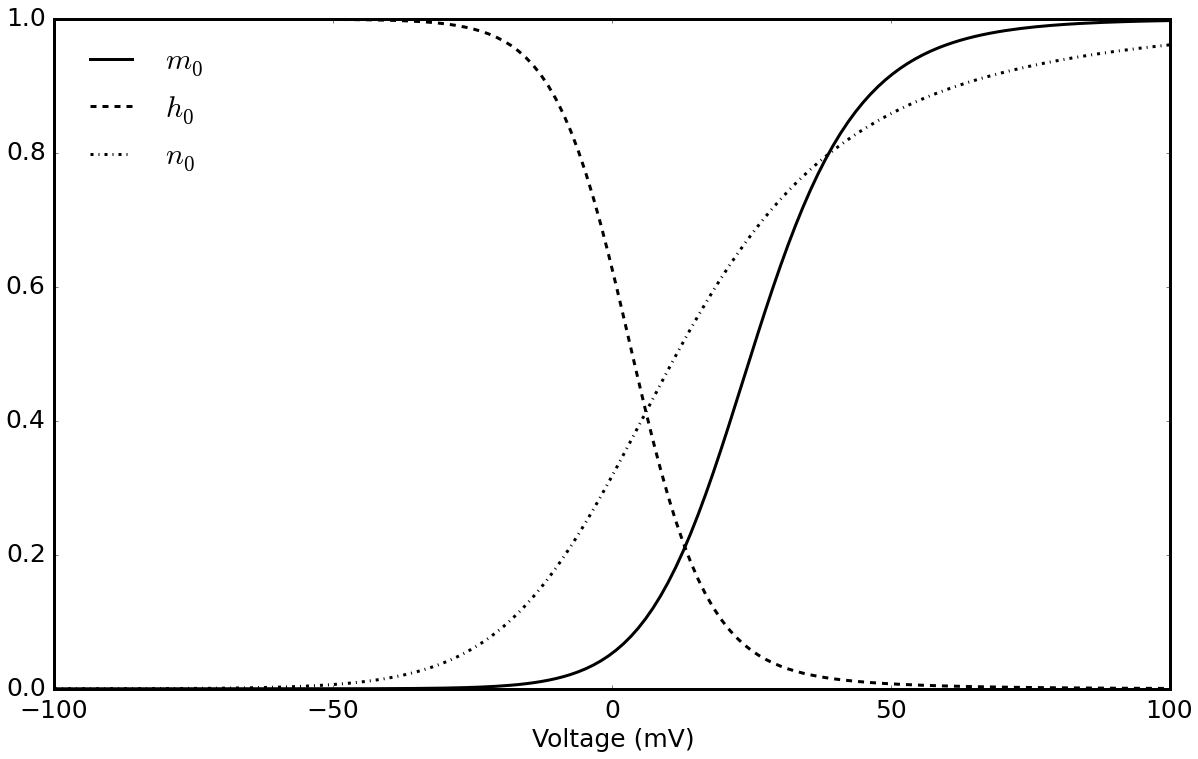

In [16]:
def plot_zeros(interval):
    x = linspace(-interval, interval, 150)
    
    m = [m_0(i) for i in x]
    h = [h_0(i) for i in x]
    n = [n_0(i) for i in x]

    plt.xlim([-interval, interval])
    plt.ylim([0, 1])
    
    plt.plot(x, m, label=r'$m_0$', color='k')
    plt.plot(x, h, label=r'$h_0$', color='k', linestyle='--')
    plt.plot(x, n, label=r'$n_0$', color='k', linestyle='-.')
    
    plt.xlabel('Voltage (mV)')
    
    plt.legend(loc='upper left')
    plt.savefig('img/zeros.jpg')
    plt.show()

widgets.interact(plot_zeros,
                    interval=widgets.FloatSlider(min=1, max=150, value=100, description="Voltage interval (mV)")
                );

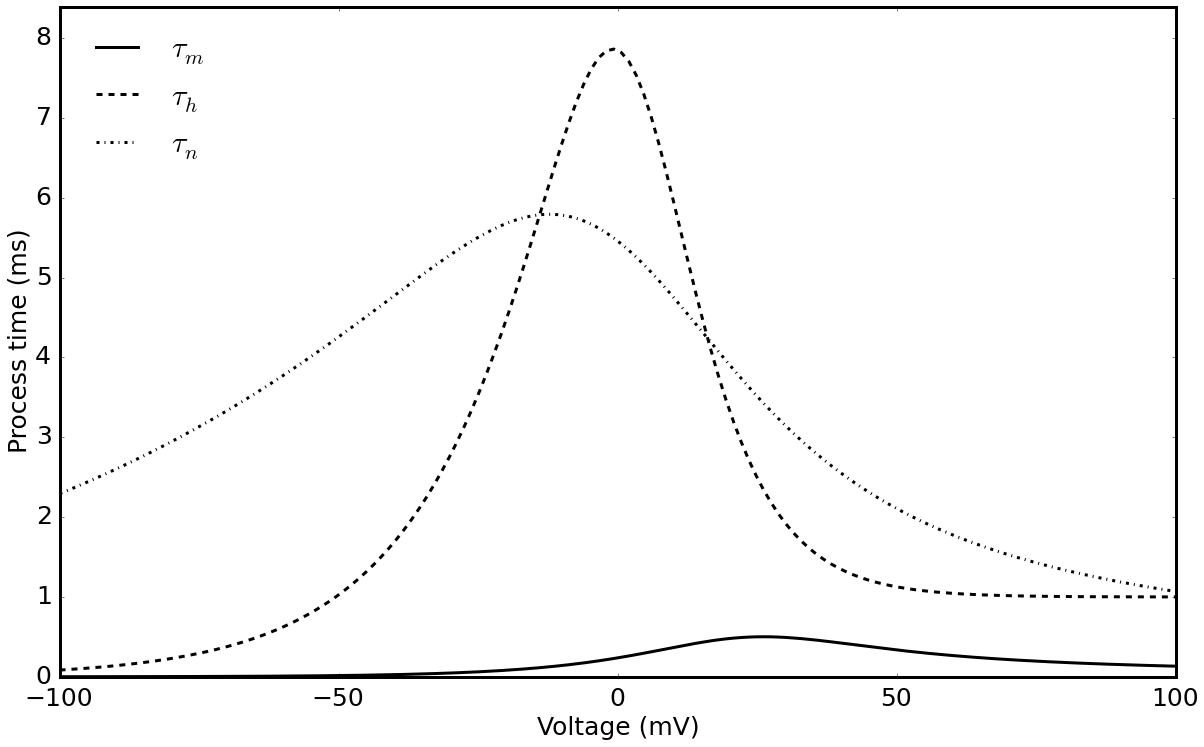

In [17]:
def plot_time(interval, temp):
    x = linspace(-interval, interval, 150)
    k = temp_factor(temp)
    
    m = [tau_m(i) / k for i in x]
    h = [tau_h(i) / k for i in x]
    n = [tau_n(i) / k for i in x]
    
    plt.xlim([-interval, interval])
    plt.ylim([0, max(h) * 16 / 15])
    
    plt.plot(x, m, label=r'$\tau_m$', color='k')
    plt.plot(x, h, label=r'$\tau_h$', color='k', linestyle='--')
    plt.plot(x, n, label=r'$\tau_n$', color='k', linestyle='-.')
    
    plt.xlabel('Voltage (mV)')
    plt.ylabel('Process time (ms)')
    
    plt.legend(loc='upper left')
    plt.savefig('img/time-%sc.jpg' % temp)
    plt.show()

widgets.interact(plot_time, 
                    interval=widgets.FloatSlider(min=1, max=150, value=100, description="Voltage interval (mV)"),
                    temp=widgets.FloatSlider(min=-25, max=25, value=6.3, description="Temperature (C)")
                );

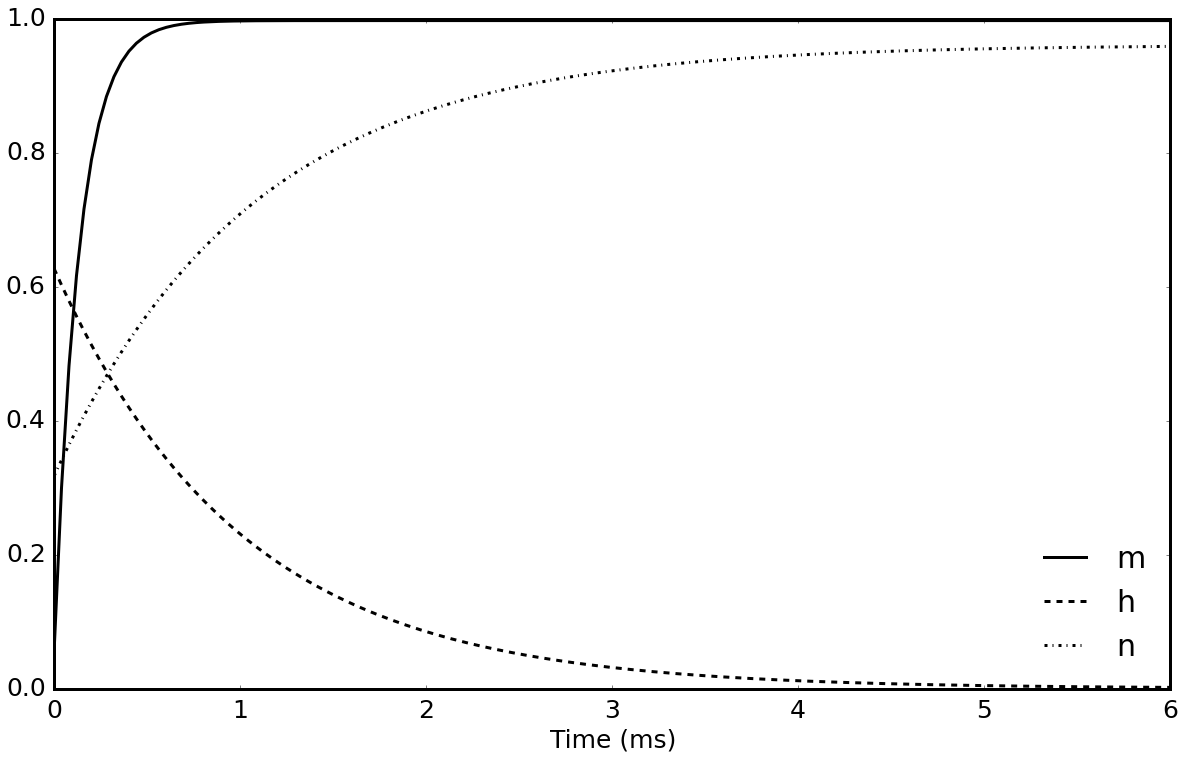

In [18]:
def plot_gating(interval, v):
    x = linspace(0, interval, 150)
    
    m = [m_fixed(v, i) for i in x]
    h = [h_fixed(v, i) for i in x]
    n = [n_fixed(v, i) for i in x]

    plt.xlim([0, interval])
    plt.ylim([0, 1])
    
    plt.plot(x, m, label=r'm', color='k')
    plt.plot(x, h, label=r'h', color='k', linestyle='--')
    plt.plot(x, n, label=r'n', color='k', linestyle='-.')
    
    plt.xlabel('Time (ms)')
    
    plt.legend(loc='lower right')
    plt.savefig('img/gating-%smv.jpg' % v)
    plt.show()

widgets.interact(plot_gating,
                    interval=widgets.FloatSlider(min=1, max=15, value=6, description="Time interval (ms)"),
                    v=widgets.FloatSlider(min=-150, max=150, value=100, description="Voltage (mV)")
                );

In [19]:
def calc_hh(x_total, t_total, a, rho, cap, g_na, g_k, g_l, v_na, v_k, v_l, v_0, temp, seg_x):
    temp_coef = temp_factor(temp)
    r = rho / (pi * a ** 2)
    c = 2 * pi * a * cap

    delta_x = x_total / seg_x
    delta_t = min((r * c * delta_x ** 2) / 3, 0.001)
    
    seg_t = int(floor(t_total / delta_t))
    
    m = zeros(shape=(seg_x + 1, seg_t + 1))
    h = zeros(shape=(seg_x + 1, seg_t + 1))
    n = zeros(shape=(seg_x + 1, seg_t + 1))
    v = zeros(shape=(seg_x + 1, seg_t + 1))
    
    for i in range(0, int(seg_x / 4)):
        v[i, 0] = v_0
    
    for i in range(0, seg_x + 1):
        m[i, 0] = m_0(0)
        h[i, 0] = h_0(0)
        n[i, 0] = n_0(0)
        
    for j in range(0, seg_t):
        for i in range(0, seg_x + 1):
            m[i, j + 1] = temp_coef * delta_t / tau_m(v[i, j]) * (m_0(v[i, j]) - m[i, j]) + m[i, j]
            h[i, j + 1] = temp_coef * delta_t / tau_h(v[i, j]) * (h_0(v[i, j]) - h[i, j]) + h[i, j]
            n[i, j + 1] = temp_coef * delta_t / tau_n(v[i, j]) * (n_0(v[i, j]) - n[i, j]) + n[i, j]

            p_na = g_na * (v[i, j] - v_na) * m[i, j] ** 3 * h[i, j]
            p_k  = g_k  * (v[i, j] - v_k)  * n[i, j] ** 4
            p_l  = g_l  * (v[i, j] - v_l)
            p    = 2 * pi * a * (p_na + p_k + p_l)
            # p is J(x, t) in the report

            if i == 0 or i == seg_x:
                v[i, j + 1] = 0
            else:
                v[i, j + 1] = delta_t / c * ((v[i + 1, j] - 2 * v[i, j] + v[i - 1, j]) / (delta_x ** 2 * r) - p) + v[i, j]

    return v

In [20]:
def plot_hh(x_total = 3, t_total = 15, a = 238, rho = 35.4, cap = 0.91, g_na = 120, g_k = 34, g_l = 0.26, v_na = 109, v_k = -11, v_l = 11, v_0 = 100, temp = 6.3, seg_x = 100, name='custom'):
    a *= 10 ** -2
    
    x = linspace(0, x_total, seg_x + 1)
    v = transpose(calc_hh(x_total, t_total, a, rho, cap, g_na, g_k, g_l, v_na, v_k, v_l, v_0, temp, seg_x))
    picked = v[::v.shape[0] / 90]
    frames = picked.shape[0]
    step = float(t_total) / frames
    top = max(array(picked).flatten())
    bottom = min(array(picked).flatten())
    fig = plt.figure()
    
    plt.legend(loc='upper right')
    plt.ylim([bottom * 15 / 16, top * 16 / 15])
    plt.xlabel('Position (cm)')
    plt.ylabel('Voltage (mV)')
    
    txt = plt.suptitle('')
    hl, = plt.plot(x, v[0], color='k')

    def animate(i):
        hl.set_ydata(picked[i])
        fig.suptitle('%.2fms' % (step * i))
        plt.draw()
        
    anim = animation.FuncAnimation(fig, animate, frames=frames)
    anim.save('video/%s.mp4' % name, writer=writer)

/usr/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


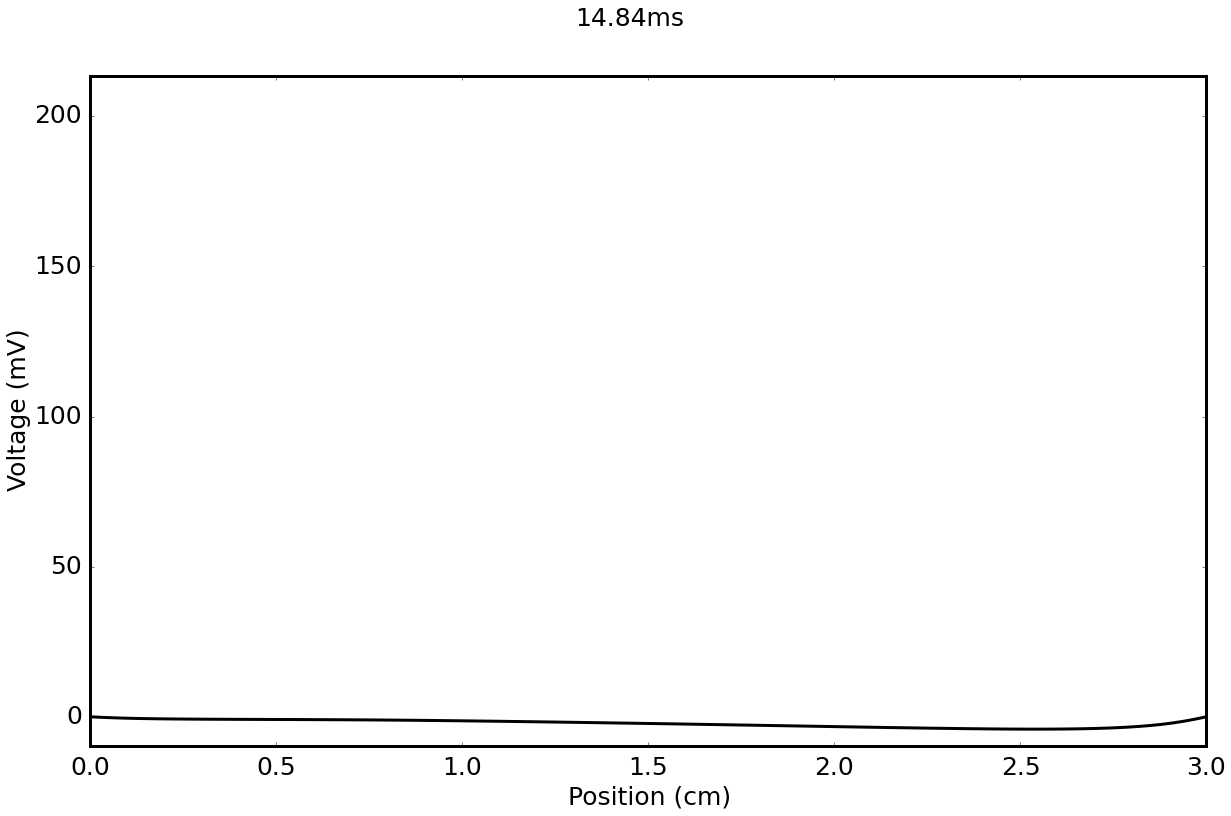

In [21]:
plot_hh(v_0 = 200, name = '200mv')

/usr/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


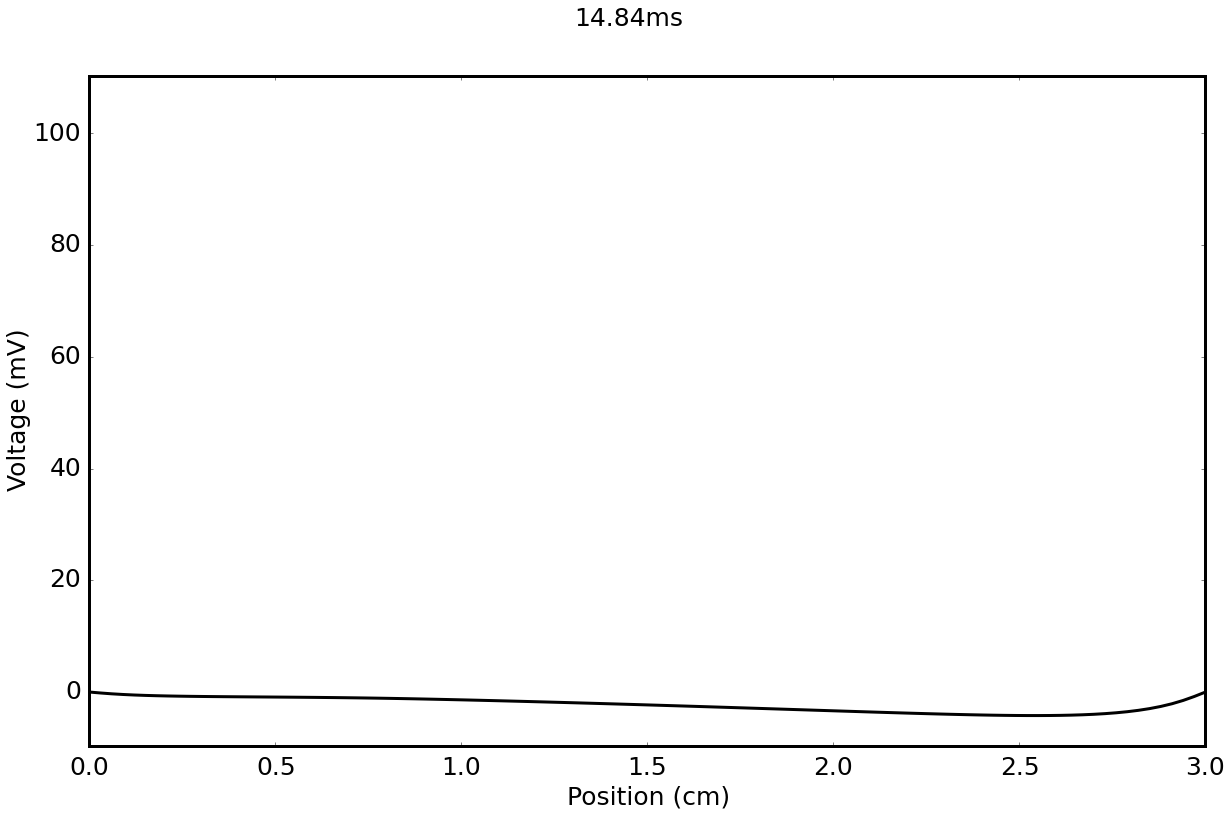

In [22]:
plot_hh(v_0 = 100, name = '100mv')

/usr/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


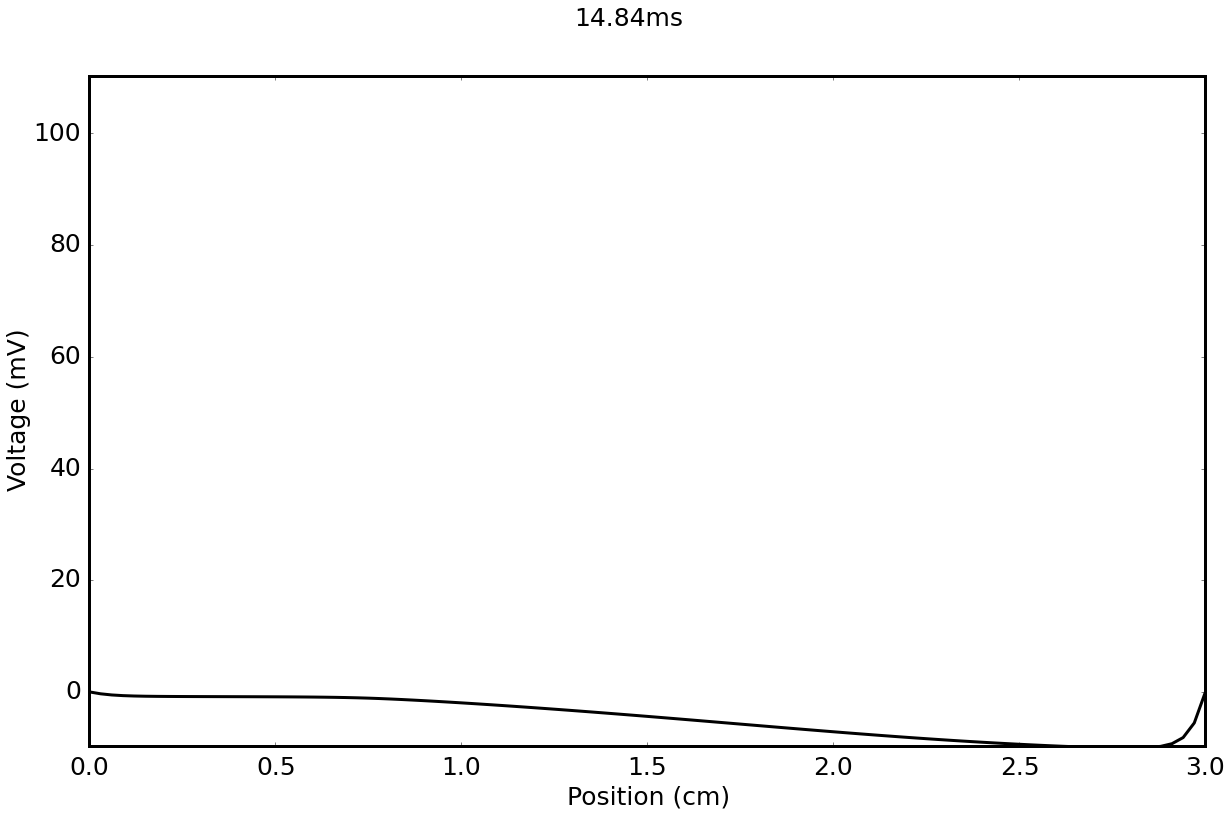

In [23]:
plot_hh(v_0 = 100, a = 50, name = '100mv-thin')

/usr/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


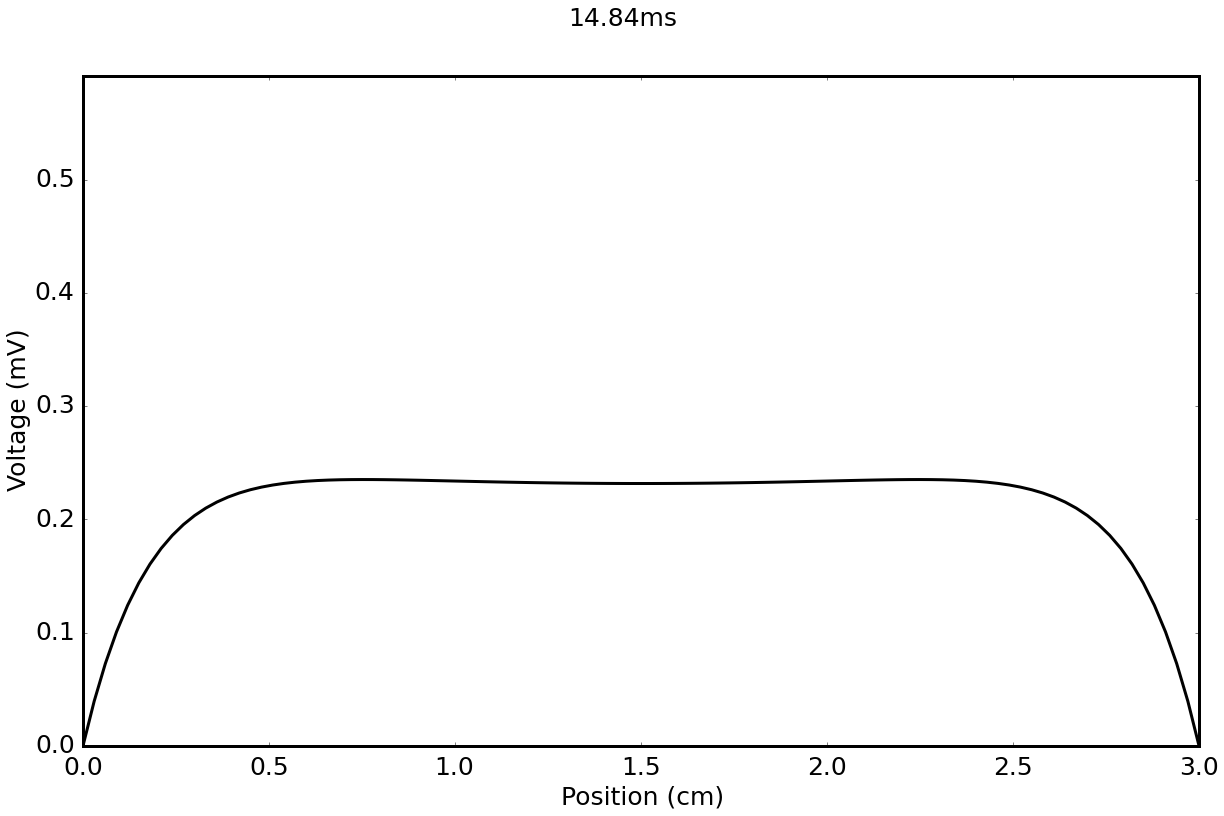

In [24]:
plot_hh(v_0 = 0, name = '0mv')

/usr/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


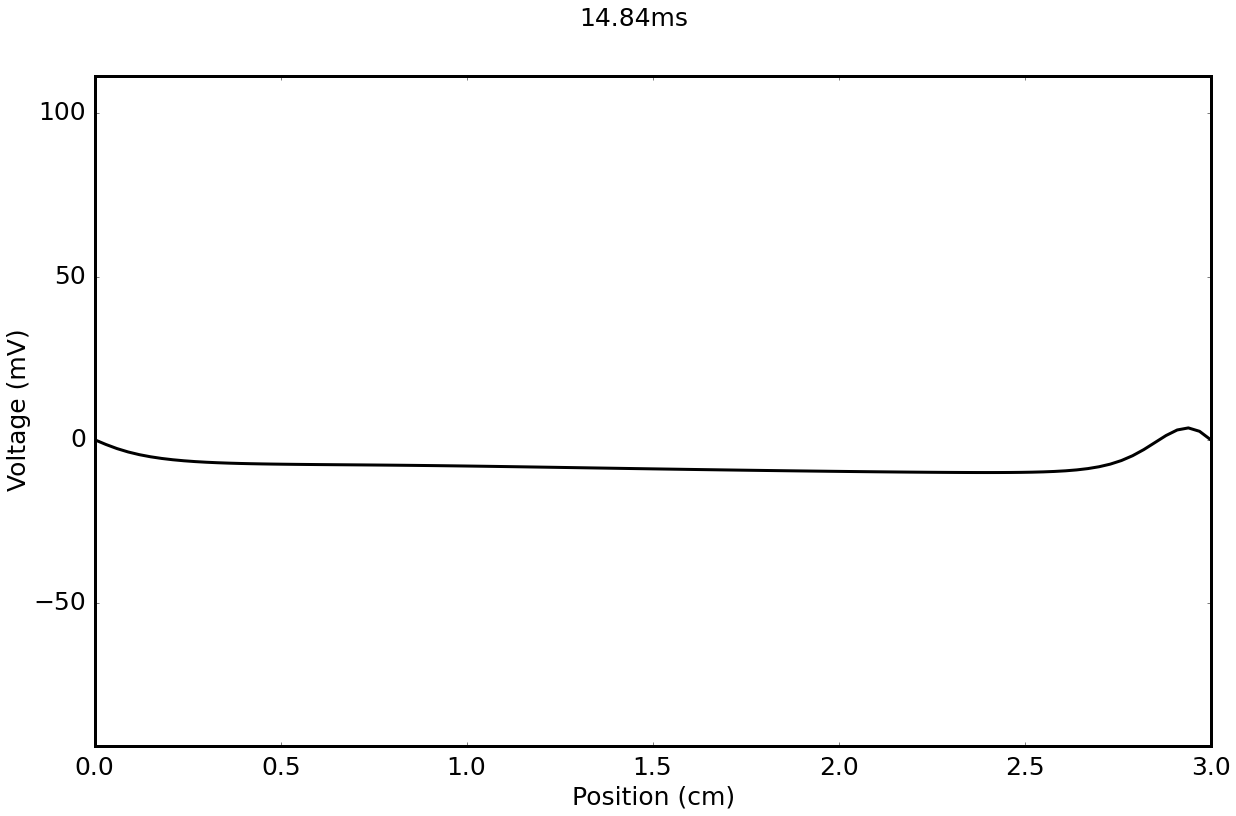

In [25]:
plot_hh(v_0 = -100, name = 'minus-100mv')

/usr/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


<function __main__.plot_hh>

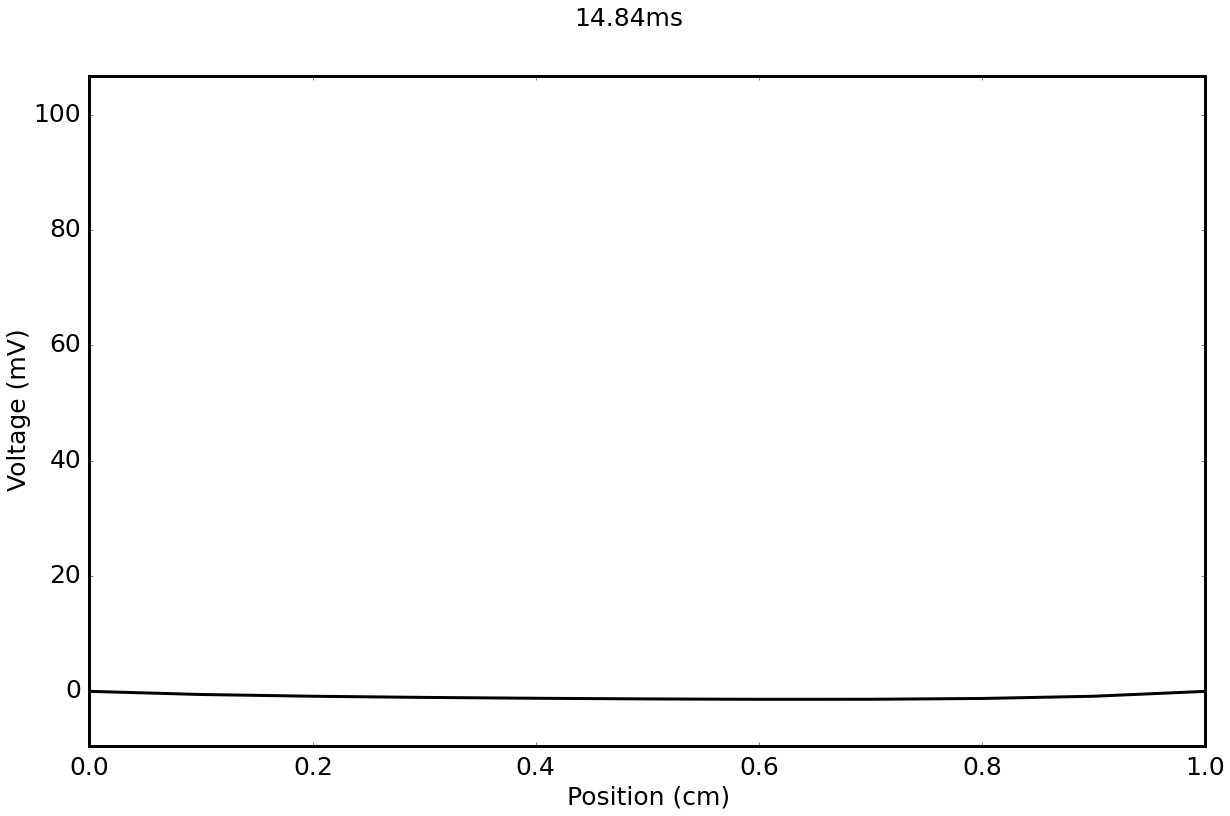

In [26]:
widgets.interact(plot_hh,
                 x_total    = widgets.FloatSlider(min = 0.1,  max = 10,  value = 1,    description = "Lenght of the axon (cm)"),
                 t_total    = widgets.FloatSlider(min = 1,    max = 25,  value = 15,   description = "Total process time (ms)"),
                 a          = widgets.FloatSlider(min = 10,   max = 300, value = 238,  description = "Axonal radius (micro m)"),
                 rho        = widgets.FloatSlider(min = 20,   max = 50,  value = 35.4, description = "Cytoplasm resistivity (ohm-m)"),
                 cap        = widgets.FloatSlider(min = 0.8,  max = 1.5, value = 0.91, description = "Square unit capacitance (micro F/cm^2)"),
                 g_na       = widgets.FloatSlider(min = 65,   max = 260, value = 120,  description = "Maximal sodium conductance (mS/cm^2)"),
                 g_k        = widgets.FloatSlider(min = 26,   max = 49,  value = 34,   description = "Maximal potassium conductance (mS/cm^2)"),
                 g_l        = widgets.FloatSlider(min = 0.13, max = 0.5, value = 0.26, description = "Maximal leakage conductance (mS/cm^2)"),
                 v_na       = widgets.FloatSlider(min = 95,   max = 119, value = 109,  description = "Sodium diffusion potential (mV)"),
                 v_k        = widgets.FloatSlider(min = -14,  max = -9,  value = -11,  description = "Potassium diffusion potential (mV)"),
                 v_l        = widgets.FloatSlider(min = 4,    max = 22,  value = 11,   description = "Leakage diffusion potential (mV)"),
                 v_0        = widgets.FloatSlider(min = -200, max = 200, value = 100,  description = "Initial voltage (mV)"),
                 temp       = widgets.FloatSlider(min = -25,  max = 25,  value = 6.3,  description = "Temperature (deg C)"),
                 seg_x      = widgets.IntSlider(  min = 5,    max = 250, value = 10,   description = "Number of space data points")
                )

In [27]:
data = genfromtxt('./result.csv', delimiter=',', skiprows=1).transpose()

In [28]:
corr = corrcoef(data)
table = '<table style="font-size: 18px"><tr><th style="font-weight: normal">Correlation matrix</th>'
headers = ['Initial voltage', 'End voltage', 'Temperature', 'Time', 'Length', 'Radius', 'Cytoplasm resistivity', 'Capacitance', 'Max sodium conductance', 'Max potassium conductance', 'Max leakage conductance', 'Sodium diffusion potential', 'Potassium diffusion potential', 'Leakage diffusion potential']

for i in range(0, len(headers)):
    table += '<th style="font-weight: normal">%s.</th>' % (i + 1)

table += '</tr>'

def scale(num):
    return 128 * (1 - pow(abs(num), 1 / 4));
    
for i in range(0, len(corr)):
    table += '<tr><td>%d. %s</td>' % (i + 1, headers[i])
    for j in range(0, i + 1):
        scaled = scale(corr[i][j])
        table += '<td style="color: rgb(%d, %d, %d)">%.2f</td>' % (scaled, scaled, scaled, corr[i][j])
        
    for j in range(i + 1, len(corr)):
        table += '<td></td>'
        
    table += '</tr>'

HTML(table)